# 0. Provision our SCNs

In [2]:
from platform_api import platform_api
from smart_broker_api import session
from getpass import getpass
import time
import warnings

# We filter out because our certs are self-signed for now
warnings.filterwarnings('ignore', message='Unverified HTTPS request')

PLATFORM_IP = "172.20.100.7"
PLATFORM_USER = "admin@secureailabs.com"
FEDERATION_NAME = "KCA Consortium - FHIR"
PASSWORD = getpass(prompt="Researcher password: ")

platform_session = platform_api.login(PLATFORM_USER, PASSWORD, PLATFORM_IP)

platform_api.provision_federation_by_name(platform_session, FEDERATION_NAME)

federation_session = None
while federation_session is None:
    time.sleep(30)
    federation_session = platform_api.connect_to_federation(platform_session, FEDERATION_NAME)

session = session.Session(federation_session["ip"], federation_session["port"], True)

print(f"Federation is up and running at {session.ip}:{session.port}")

Researcher password:  ········


Id for federation is b3f77c0b-3d07-47fa-9057-7210b7d6e225
{'data_federation_id': 'b3f77c0b-3d07-47fa-9057-7210b7d6e225', 'secure_computation_nodes_size': 'Standard_D4s_v4'}
Provision id b6da95b4-36e9-4f13-9caa-0e964c8b299b
Smart broker id: c1248e10-abc9-48ca-acd9-c5dcef911a71
Federation is being provisioned...
Federation is being provisioned...
Federation is being provisioned...
Federation is being provisioned...
Federation is being provisioned...
Federation is being provisioned...
Federation is being provisioned...
Federation is up and running at 172.20.200.6:8000


In [3]:
from smart_broker_api import data_model_api

DATA_FRAME_NAME = "data_frame_demo"

data_model_id = data_model_api.create_date_frame(session, DATA_FRAME_NAME)
data_model_api.data_frame_add_series(session, data_model_id, "bmi_mean", "Observation:Body Mass Index", "AgregatorIntervalMean")
data_model_api.data_frame_add_series(session, data_model_id, "bmi_first", "Observation:Body Mass Index", "AgregatorIntervalFirstOccurance")
data_model_api.data_frame_add_series(session, data_model_id, "bmi_last", "Observation:Body Mass Index", "AgregatorIntervalLastOccurance")
data_model_tabular_id = data_model_api.create_tabular_data(session)
data_model_tabular_id = data_model_api.tabular_add_dataframe(session, data_model_id, data_model_tabular_id)

# 2. Flatten / Aggregate data from Aggregation model

In [4]:
from smart_broker_api import data_api

dataset_federation_id = "a892f738-4f6f-11ed-bdc3-0242ac120002"

longitudinal_id = data_api.read_longitudinal_fhirv1(session)
tabular_dataset_id = data_api.parse_dataset_tabular_from_longitudinal(session, longitudinal_id, dataset_federation_id, FEDERATION_NAME, data_model_tabular_id)
data_frame_id = data_api.data_frame_tabular_select_data_frame(session, tabular_dataset_id, DATA_FRAME_NAME)

# 3. Remove NaNs from data frame

In [5]:
from smart_broker_api import preprocessing_api

no_nan_data_frame_id = preprocessing_api.drop_na_data_frame(session, data_frame_id)

# 4. Grab series to work with in Statistics Lib

In [6]:
series_1_id = data_api.data_frame_select_series(session, no_nan_data_frame_id, "bmi_mean")
series_2_id = data_api.data_frame_select_series(session, no_nan_data_frame_id, "bmi_last")

print(series_1_id+" , "+series_2_id)

6c3c11c9-86e0-45bf-a9a7-67c124ef7f3e , 8a798b3c-9c57-4df1-9ac9-a4c16b02f1da


# 5. Cohort selection

In [7]:
from smart_broker_api import preprocessing_api
from smart_broker_api import statistics_api

query = "bmi_first > bmi_last"
query_dataframe = preprocessing_api.query_data_frame(session, no_nan_data_frame_id, query)
query_series = data_api.data_frame_select_series(session, query_dataframe, "bmi_last")

print(f"Patients whose BMI decreased during study: {statistics_api.count(session,  query_series)}")

query = "bmi_first < bmi_last"
query_dataframe = preprocessing_api.query_data_frame(session, no_nan_data_frame_id, query)
query_series = data_api.data_frame_select_series(session, query_dataframe, "bmi_last")

print(f"Patients whose BMI increased during study: {statistics_api.count(session,  query_series)}")

query = "bmi_first - bmi_last > 0.5"
query_dataframe = preprocessing_api.query_data_frame(session, no_nan_data_frame_id, query)
query_series = data_api.data_frame_select_series(session, query_dataframe, "bmi_last")

print(f"Patients whose BMI significantly decreased during study: {statistics_api.count(session,  query_series)}")

print(f"Mean BMI of patients whose BMI significantly decreased: {statistics_api.mean(session, query_series)} ")

Patients whose BMI decreased during study: {'count': 11}
Patients whose BMI increased during study: {'count': 20}
Patients whose BMI significantly decreased during study: Validation Failure: Sample size too small
Mean BMI of patients whose BMI significantly decreased: Validation Failure: Sample size too small 


# 6. Run Statistics Library

{'count': 39}
{'mean': 24.077978156595098}
{'chisquare': [1482.0, 0.23780643207804403]}
{'kolmogorov_smirnov_test': [0.9487179487179487, 9.765177766940755e-51]}
{'kurtosis': -1.0554004280481166}
{'f_statistic': 0.4727228384348489, 'p_value': 0.4938301638491879}
{'w_statistic': 744.0, 'p_value': 0.8729644921296094}
{'min': 10.752068498358543, 'max': 35.31937886703387}
{'t_statistic': -4.130790631792744, 'p_value': 4.779885698623219e-05}
{'pearson': 0.9478269693987692, 'p_value': 0.0}
{'skewness': -0.3911170171411883}
{'spearman': 0.9603105783145206, 'p_value': 0.0}
{'t_statistic': -0.9446940149624719, 'p_value': 0.08695220786668137}
{'variance': 30.349529322447076}
{'t_statistic': -0.9446940149624716, 'p_value': 0.08695241043625684}
{'w_statistic': 0.9603105783145206, 'p_value': 0.0}
{'w_statistic': 0.9603105783145206, 'p_value': 0.0}


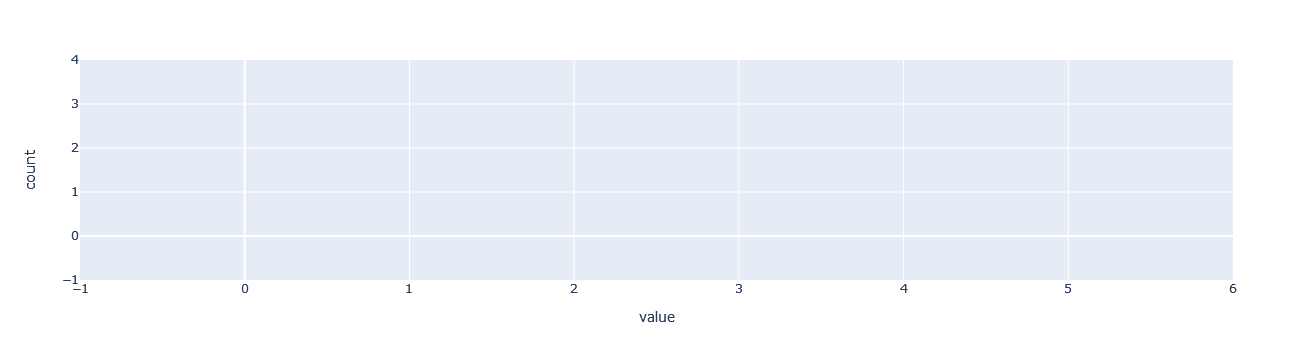

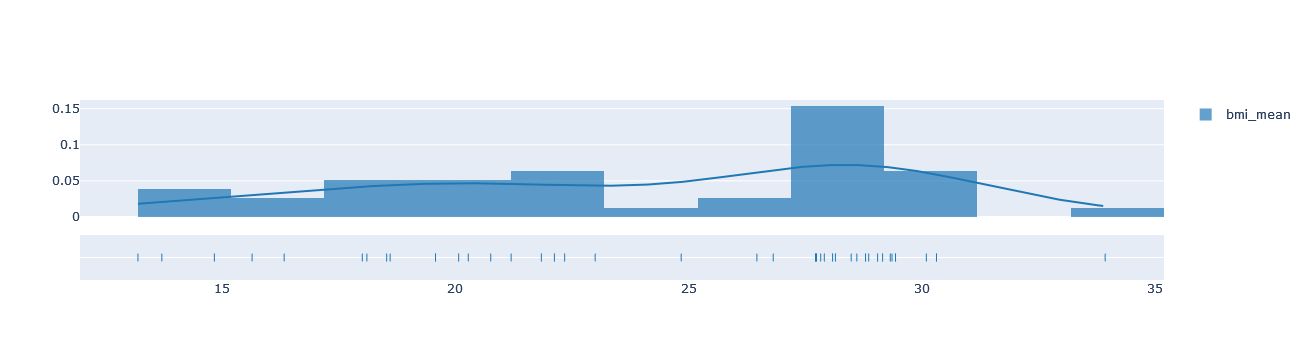

In [9]:
from smart_broker_api import statistics_api
from smart_broker_api import visualization_api
import plotly.graph_objects as go

type_distribution="normalunit"
type_ranking="cdf"
alternative = "two-sided"
print(statistics_api.count(session,  series_1_id))
print(statistics_api.mean(session,  series_1_id))
print(statistics_api.chisquare(session,  series_1_id, series_2_id))
print(statistics_api.kolmogorovSmirnovTest(session,  series_1_id, type_distribution, type_ranking))
print(statistics_api.kurtosis(session,  series_1_id))
print(statistics_api.levene_test(session,  series_1_id, series_2_id))
print(statistics_api.mann_whitney_u_test(session,  series_1_id, series_2_id, alternative, type_ranking))
print(statistics_api.min_max(session,  series_1_id))
print(statistics_api.paired_t_test(session,  series_1_id, series_2_id, alternative))
print(statistics_api.pearson(session,  series_1_id, series_2_id, alternative))
print(statistics_api.skewness(session,  series_1_id))
print(statistics_api.spearman(session,  series_1_id, series_2_id, alternative, type_ranking))
print(statistics_api.student_t_test(session,  series_1_id, series_2_id, alternative))
print(statistics_api.variance(session,  series_1_id))
print(statistics_api.welch_t_test(session,  series_1_id, series_2_id, alternative))
print(statistics_api.wilcoxon_signed_rank_test(session,  series_1_id, series_2_id, alternative, type_ranking))
print(statistics_api.wilcoxon_signed_rank_test(session,  series_1_id, series_2_id, alternative, type_ranking))



dict_of_fig = visualization_api.histogram(session, series_1_id, 20)
fig = go.Figure(dict_of_fig["figure"])
fig.show()


dict_of_fig = visualization_api.kernel_density_estimation(session, series_1_id, 2)
fig = go.Figure(dict_of_fig["figure"])
fig.show()

# 7. Deprovision our Federation

In [10]:

platform_api.deprovision_federation_by_name(platform_session, FEDERATION_NAME)


Deprovision ID is b6da95b4-36e9-4f13-9caa-0e964c8b299b


In [10]:
from platform_api import platform_api

PROVISION_ID = "0de43d62-fb01-4c34-aaae-3f77a73f71e7"
PASSWORD="SailPassword@123"

platform_session = platform_api.login("admin@secureailabs.com", PASSWORD, "172.20.100.5")

platform_api.deprovision_federation_by_id(platform_session, PROVISION_ID)